---

_You are currently looking at **version 1.5** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

# How much jobs will be terminated by automation?






 
 Each row in the assignment datafile corresponds to a single observation.
 
 The following variables are provided to you:
 
 * **id** : station identification code
 * **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
 * **element** : indicator of element type
     * TMAX : Maximum temperature (tenths of degrees C)
     * TMIN : Minimum temperature (tenths of degrees C)
 * **value** : data value for element (tenths of degrees C)
 

 The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import math
import heapq

In [2]:
# I did some manual data cleaning job on the exel file to make the code easier:(
df = pd.read_csv('data.csv')
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}
state = ''
df['state'] = ''
df['Area'] = df['Area'].str.split('(').str[0]

df.iloc[0].Area in states.values()
for i in range(0,len(df)):    
    if df['Area'][i] in states.values():
        state = list(states.keys())[list(states.values()).index(df['Area'][i])]            
    elif math.isnan(df.Total[i]) == False:
        df['state'][i] = state
df = df.dropna()

# state dataframe
sdf = df.where(df['state'] == '').dropna().set_index(['Area']).apply(pd.to_numeric, errors='coerce')

# area dataframe
adf = df.where(df['state'] != '').dropna().set_index(['Area', 'state']).apply(pd.to_numeric, errors='coerce')

# matching the terminating risk of industrial sections. I made the file based on the pdf file.
wf = pd.read_csv('WholeEmployment.csv', index_col = 0, skiprows = 1, usecols=[0,1,5,6])   
wf = wf.sort_values(by = 'PEO', ascending = False)
wf['Risk R of England'] = wf.Esection.str.findall('(\d+.\d+)').str[1].astype(float)
wf['Esection'] = wf.Esection.str.split('\s\d').str[0]
wf = wf.dropna()
wf['PEO'].astype(float)

# calculating Weighted average of risk ratio
R_R = {}
for group, frame in wf.groupby('BigSection'):
    gsum = sum(frame['PEO'])
    R_R[group] = sum((frame['PEO']/gsum) * frame['Risk R of England'])
    print(gsum)    
keys = R_R.keys()

# applying ratio to american industrial section classification.
def aSum(row):
    data = []
    asum = 0
    for i in keys:
        data.append(round((row[i] / row['Total'] *100), 2))
        if math.isnan(row[i]) == False:
            asum += row[i] * R_R[i]            
    high3 = heapq.nlargest(3, zip(data, keys))      
    data1 = [asum / row['Total'], row['Total'], high3]    
    return pd.Series(data1)

C:\Users\bauha\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


4.3
14.5
5.3
14.200000000000001
1.8
10.0
7.9
0.4
9.7
12.9
17.499999999999996


<IPython.core.display.Javascript object>


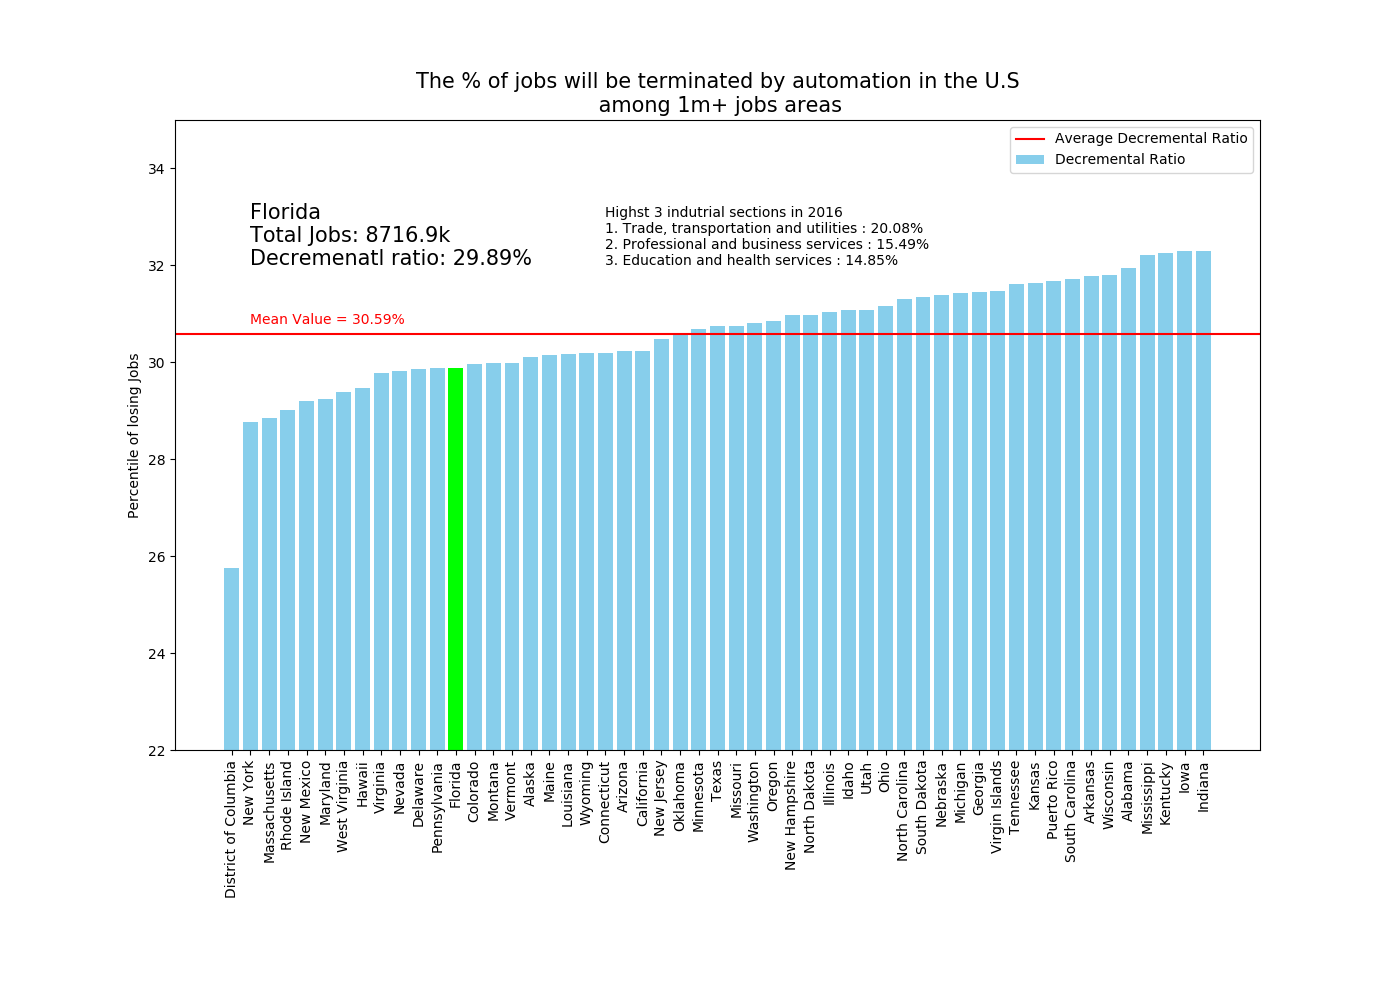

No handles with labels found to put in legend.


8

In [15]:


### defining scale of jobs.
#l_cap = 1000
#rf = adf.apply(aSum, axis = 1)
#rf.columns = ['Decremnetal R', 'Total', 'High3']
###kf = rf[(rf['Total'] > l_cap) & (rf['Total'] <= h_cap)].sort_values(by = ['Decremnetal R'])
#rf = rf[(rf['Total'] > l_cap)].sort_values(by = ['Decremnetal R'])
### mean is mean for the whole scale.
#mean = rf['Decremnetal R'].mean()
##rf = rf.drop(rf.index[15:-15])
#rf.reset_index(inplace = True)
#rf['Area'] = rf['Area'] + ", " + rf['state']
#rf = rf.drop(['state'], axis = 1)
#x = rf.index
#y = rf['Decremnetal R'].values
#total = rf['Total'].values
#area = rf.Area.values

sf = sdf.apply(aSum, axis = 1)
sf.columns = ['Decremnetal R', 'Total', 'High3']
sf = sf.sort_values(by = ['Decremnetal R'])
sf = sf.reset_index()
x = sf.index
y = sf['Decremnetal R'].values.astype(float)
total = sf['Total'].values
mean = sf['Decremnetal R'].mean()
area = sf.Area.values

%matplotlib qt

plt.figure(figsize = [14,10])
plt.bar(x,y)
axes = plt.gca()
axes.set_ylim([22,35])
plt.xticks(x, area, rotation = 90)
plt.ylabel('Percentile of losing Jobs')
plt.title('How many % of jobs will be terminated by the automation in U.S')
plt.title('the Best and the Worst')
plt.legend(loc=4, frameon=False, title='Legend')
plt.show()


def mouseMove(event):

    colors = ['skyblue'] * len(x)
    plt.cla()
    xd = int(round(event.xdata))
    #high = rf.High3[xd]
    high = sf.High3[xd]
    colors[xd] = 'lime'
    plt.bar(x,y, color = colors)
    axes = plt.gca()
    axes.set_ylim([22,35])    
    plt.xticks(x, area, rotation = 90, size = 10)
    plt.ylabel('Percentile of losing Jobs')
    #plt.title('The % of jobs will be terminated by automation in the U.S', size = 15)
    plt.title('The % of jobs will be terminated by automation in the U.S\n among 1m+ jobs areas', size = 15)
    plt.gcf().subplots_adjust(bottom=0.25)
    #plt.legend(['Baseline', 'Competition', 'Us'])
    plt.axhline(y=mean, color='r', linestyle='-')
    plt.annotate('{}\nTotal Jobs: {}k\nDecremenatl ratio: {}%'.format(area[xd], total[xd], round(y[xd],2)), size = 15, xy = (1, 32))
    plt.annotate('Highst 3 indutrial sections in 2016\n1. {} : {}%\n2. {} : {}%\n3. {} : {}%'.format(high[0][1], high[0][0], high[1][1], high[1][0],high[2][1], high[2][0]), size = 10, xy = (20, 32))  
    plt.annotate('Mean Value = {}%'.format(round(mean, 2)), color = 'red', xy = (1, round(mean, 2) + .2))
    plt.legend(['Average Decremental Ratio', 'Decremental Ratio'] )
    plt.draw()
plt.gcf().canvas.mpl_connect('motion_notify_event', mouseMove)